In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict
import pmdarima as pm
from sklearn.metrics import mean_squared_error
sns.set()

In [2]:
demand=pd.read_csv('../data/processed/load_data.csv',index_col='time',parse_dates=True)

In [3]:
weather=pd.read_csv('../data/processed/weather_new_data.csv',index_col='dt_iso',parse_dates=True)

Box-Jenkins

- Time Series Identifcation
    - Stationary or non stationary?
    - Determing Seasonality
- Parameter Estimation:
    - The AR and MA coefficiants will need to be estimated. This will be done automatically using the .fit() method
    - Orders of MA and AR will need to be estimated. This can be done by looping over multiple orders and comparing the AIC/BIC scores.
- Model Diagnostic: 
    - Are the residuals uncorrelated?
    - Are residuals normally distributed?
    - Plotting diagnostic and looking at hypothesis tests?
    - If residuals look good, model can proceed to forecasting.
    - If not, model will need to be optimized.
    
We will first set up our train and test data. We will train on the years of 2015,2016 and 2017. We will test on data from 2018. We aim to predict the total value of weekly demand.

In [461]:
#aggreagting demand by week
demand_actual=demand['total load actual']
weekly_demand=demand_actual.resample("W").sum()

In [462]:
#setting up train and test datasets
demand_train=weekly_demand[weekly_demand.index.year.isin([2015,2016])]
demand_test=weekly_demand[weekly_demand.index.year.isin([2017,2018])]

We will create all the features that might be useful to predict demand using the different models and we will reduce them as we understand their importance in the respective models.

In [453]:
#weather features
x1=weather.temp_c.resample("W").mean() #mean temperature
x2=weather.temp_c_max.resample("W").max() #max temperature
x3=weather.temp_c_min.resample("W").min() # min temperature
x4=weather.pressure.resample("W").mean() #mean pressure
x5=weather.humidity.resample("W").mean() # mean humidity
x6=weather.wind_speed.resample("W").max() #max wind speed



#percentage change features
x7=pd.Series(weather.temp_c.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of mean temperature
x8=pd.Series(weather.temp_c_max.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of max temperature
x9=pd.Series(weather.temp_c_min.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of min temperature
x10=pd.Series(weather.pressure.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of mean pressure
x11=pd.Series(weather.humidity.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of mean humidity
x12=pd.Series(weather.wind_speed.resample("W").max().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of max wind speed

#Datetime features
x13=pd.Series(x1.index.weekofyear.values, index=x1.index, name="week") #week of year
x14=pd.Series(x1.index.month.values, index=x1.index, name='month') #month of year
x15=pd.Series(x1.index.quarter.values, index=x1.index, name='quarter') #quarter of year

In [455]:
X=pd.DataFrame(data=[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15]).T
X_train=X.loc[X.index.year.isin([2015,2016])].values
X_test=X.loc[X.index.year.isin([2017,2018])].values

# 1. Identification

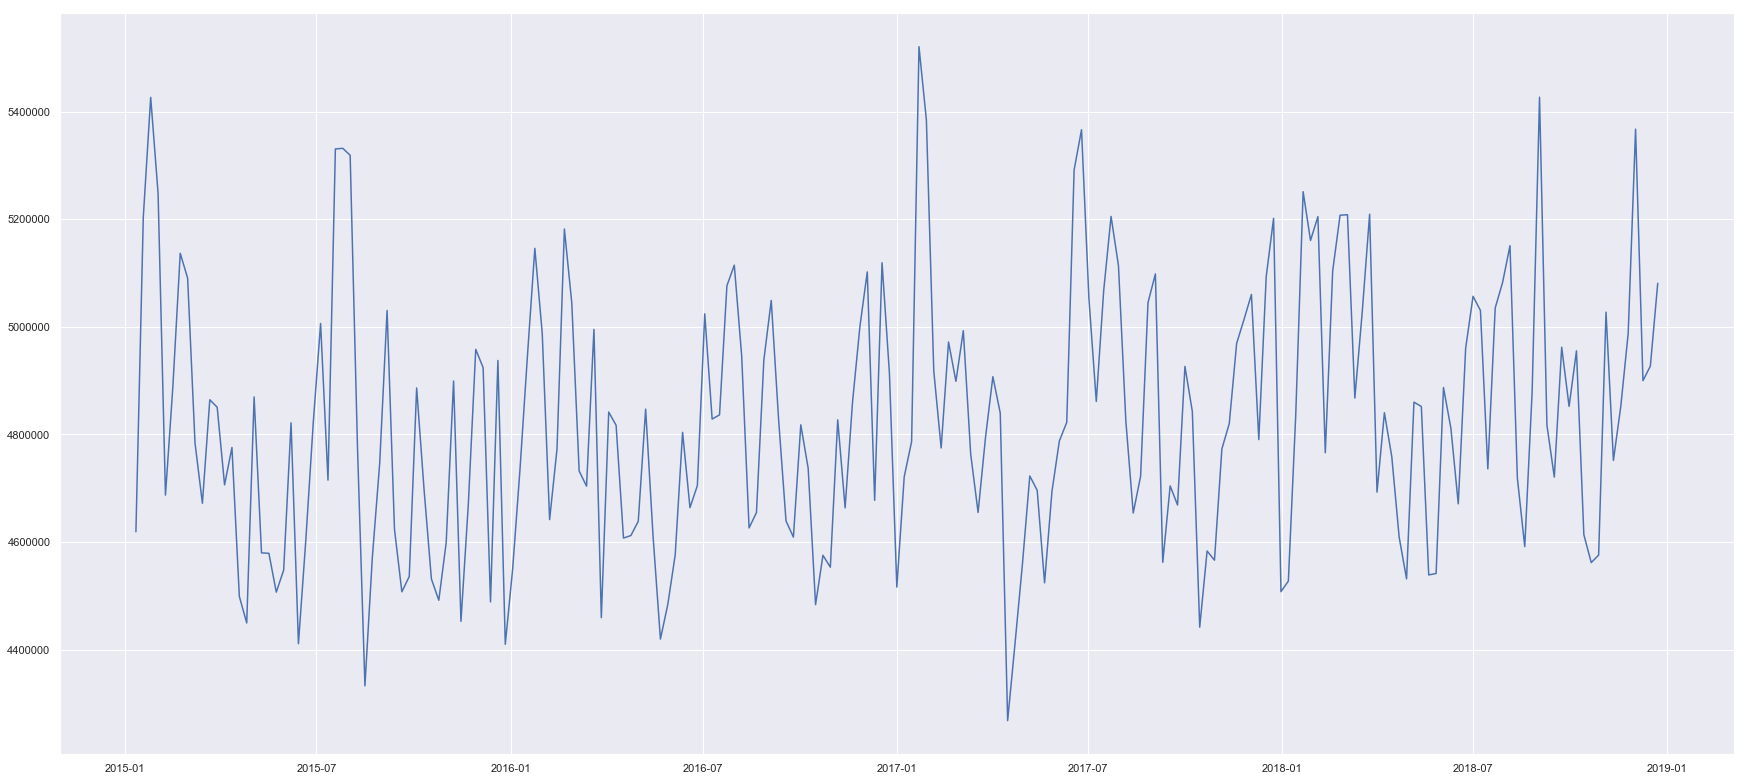

In [327]:
plt.figure(figsize=[30,30])
plt.subplot(2,1,1)
plt.plot(weekly_demand);

In [25]:
dicky_train=adfuller(demand_train)
dicky_all=adfuller(weekly_demand)
print("Training set: p-value: " + str(dicky_train[1]) + " ,Test stat: "+ str(dicky_train[0]) )
print("Full data: p-value: " + str(dicky_all[1]) + " ,Test stat: "+ str(dicky_all[0]) )

Training set: p-value: 3.8951078762760736e-07 ,Test stat: -5.835002152814778
Full data: p-value: 0.00018606989323907146 ,Test stat: -4.513262054162905


Using the Dicky-Fuller test, we see a very low p-value and highly negative test statistic meaning the dataset can be considered stationary. There is no need to transform the data.

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



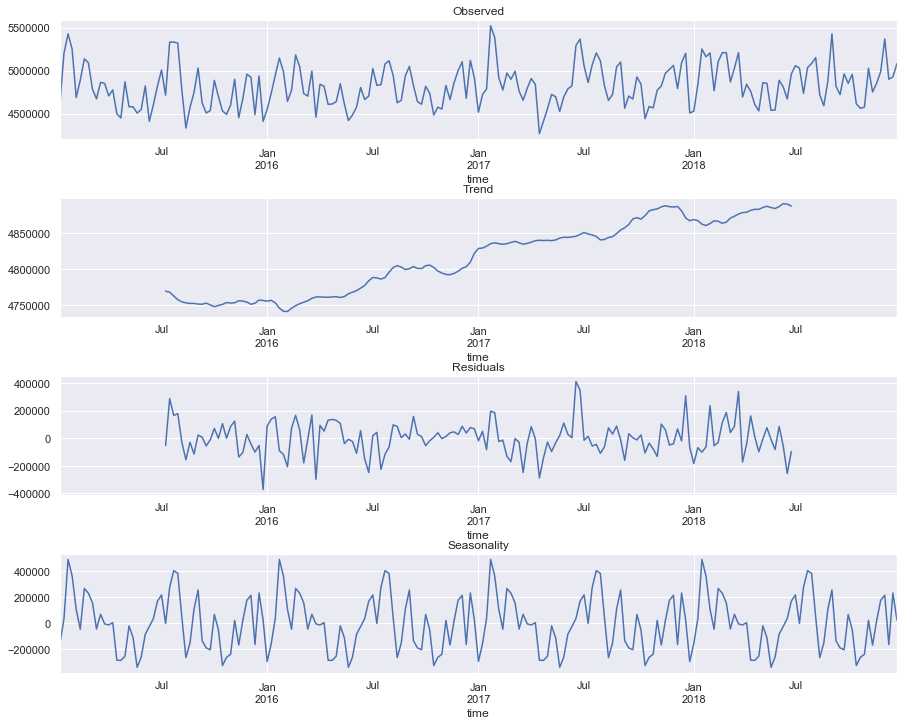

In [26]:
pd.plotting.register_matplotlib_converters()
res=seasonal_decompose(weekly_demand, freq=52)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,12))
plt.subplots_adjust(hspace=0.5)

res.observed.plot(ax=ax1)
ax1.set_title("Observed")

res.trend.plot(ax=ax2)
ax2.set_title("Trend")

res.resid.plot(ax=ax3)
ax3.set_title("Residuals")

res.seasonal.plot(ax=ax4)
ax4.set_title("Seasonality");

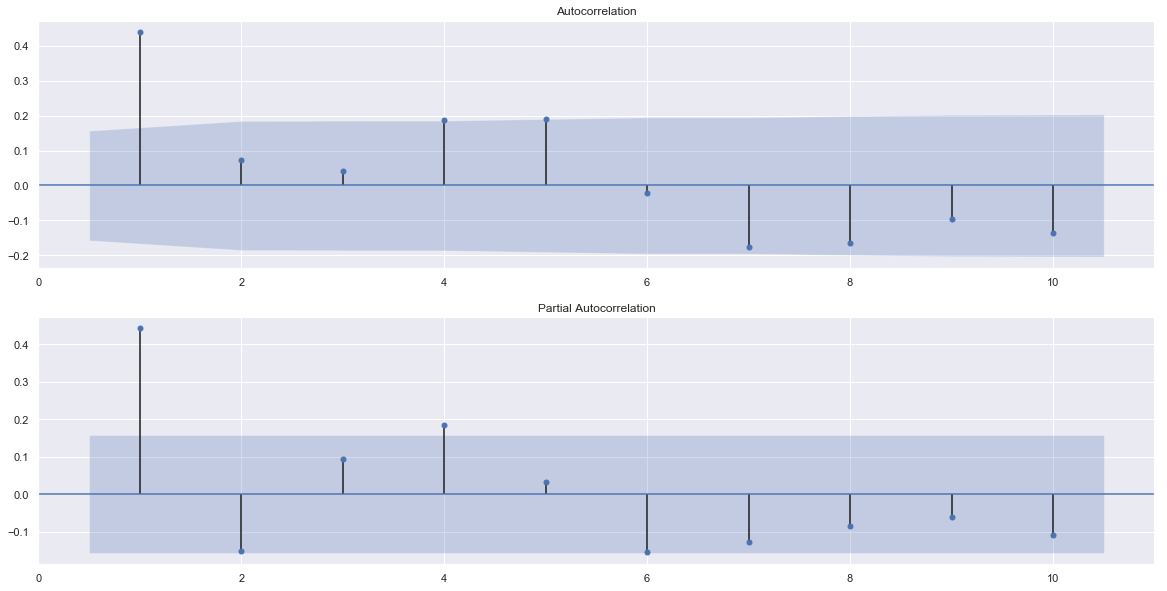

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))

plot_acf(demand_train, lags=10, zero=False, ax=ax1)
plot_pacf(demand_train, lags=10, zero=False, ax=ax2);

# 2. Paramater Estimation - Seasonsal Arima Model 

In [489]:
orders=pm.auto_arima(demand_train[1:-1], exogenous=X_train[1:-1],
                      seasonal=True, m=52,
                      d=0, D=0, 
                      start_p=1, start_q=1,
                      max_p=3, max_q=3,
                      max_P=3, max_Q=3,
                      trace=True, trend='c',
                      error_action='ignore',
                      suppress_warnings=True) 

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2826.233, BIC=2870.857, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2809.090, BIC=2858.965, Fit time=1.283 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2826.233, BIC=2870.857, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2819.047, BIC=2866.296, Fit time=0.047 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan 

We will select paramaters with the lowest AIC & BIC which respresents the best model for prediction.
- The parameters (2,0,0)(1,0,0,52) seem to provide the lowest AIC
- The parameters (2,0,0)(1,0,0,52) seem to provide the lowest BIC

Let's test (2,0,0)(1,0,0,52) first.

In [490]:
#fitting model to low AIC parameters
m1= SARIMAX(demand_train[1:-1], order=(0,0,1), seasonal_order=(1,0,0,52) ,exog=X_train[1:-1], trend='c')
r1=m1.fit()

In [491]:
#summary diagnostics
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                  total load actual   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 52)   Log Likelihood               -1384.736
Date:                            Sat, 01 Feb 2020   AIC                           2807.473
Time:                                    17:28:54   BIC                           2857.347
Sample:                                01-11-2015   HQIC                          2827.669
                                     - 12-18-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7117.2388   2.86e+06     -0.002      0.998   -5.62e+06     5.6e+06
x1          7782.3317   4.01e+04      0.194      0.846   -7.08e+04    8.64e+04
x2         -1.204e+04    2.1e+04     -0.574      0.566   -5.32e+04    2.91e+04
x3          1.068e+04   2.49e+04      0.430      0.668   -3.81e+04    5.94e+04
x4          4561.6428   5119.132      0.891      0.373   -5471.671    1.46e+04
x5          -448.8538   8876.452     -0.051      0.960   -1.78e+04    1.69e+04
x6          4.422e+04   2.57e+04      1.722      0.085   -6109.353    9.46e+04
x7            6.1e+05   9.63e+04      6.335      0.000    4.21e+05    7.99e+05
x8          5.282e+05   4.35e+05      1.216      0.224   -3.23e+05    1.38e+06
x9         -1.079e+06   4.45e+05     -2.423      0.015   -1.95e+06   -2.06e+05
x10        -4.812e+05   7.42e+05     -0.648      0.517   -1.94e+06    9.73e+05
x11          3.36e+05   4.16e+05      0.808      0.419   -4.79e+05    1.15e+06
x12        -1.083e+05   9.24e+04     -1.172      0.241   -2.89e+05    7.27e+04
x13        -3920.2764   7030.390     -0.558      0.577   -1.77e+04    9859.034
x14        -2.471e+04   5.26e+04     -0.470      0.639   -1.28e+05    7.84e+04
x15         1.118e+05   1.69e+05      0.660      0.509    -2.2e+05    4.44e+05
ma.L1          0.2323      0.123      1.882      0.060      -0.010       0.474
ar.S.L52       0.4553      0.146      3.122      0.002       0.169       0.741
sigma2      3.848e+10     66.542   5.78e+08      0.000    3.85e+10    3.85e+10
===================================================================================
Ljung-Box (Q):                       38.56   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.54   Prob(JB):                         0.73
Heteroskedasticity (H):               0.48   Skew:                             0.19
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.04e+24. Standard errors may be unstable.
"""

Prob (Q) and Prob(JB) > 0.05 which is great, meaning that the residuals are normally distibuted and are uncorrelated.

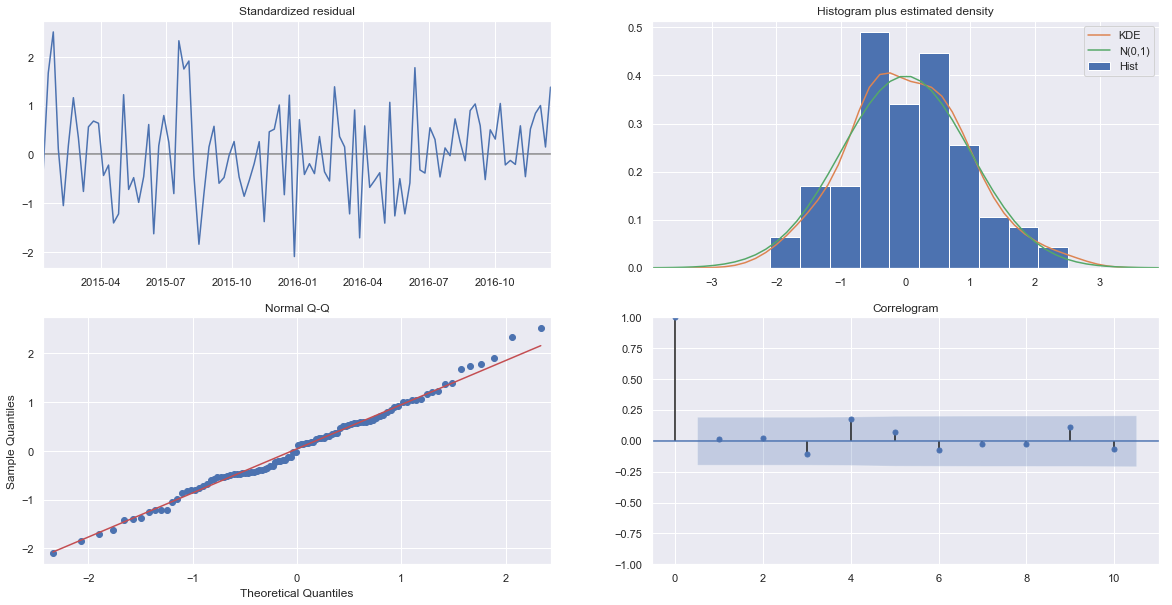

In [492]:
#plotting summary diagnostics
r1.plot_diagnostics(figsize=[20,10]);

Q-Q plot 

In [494]:
#predicting demand on training set
forecast_1=r1.get_prediction(start=-len(X_train[1:-1]), exog=X_train[1:-1])
mean_forecast_1=forecast_1.predicted_mean

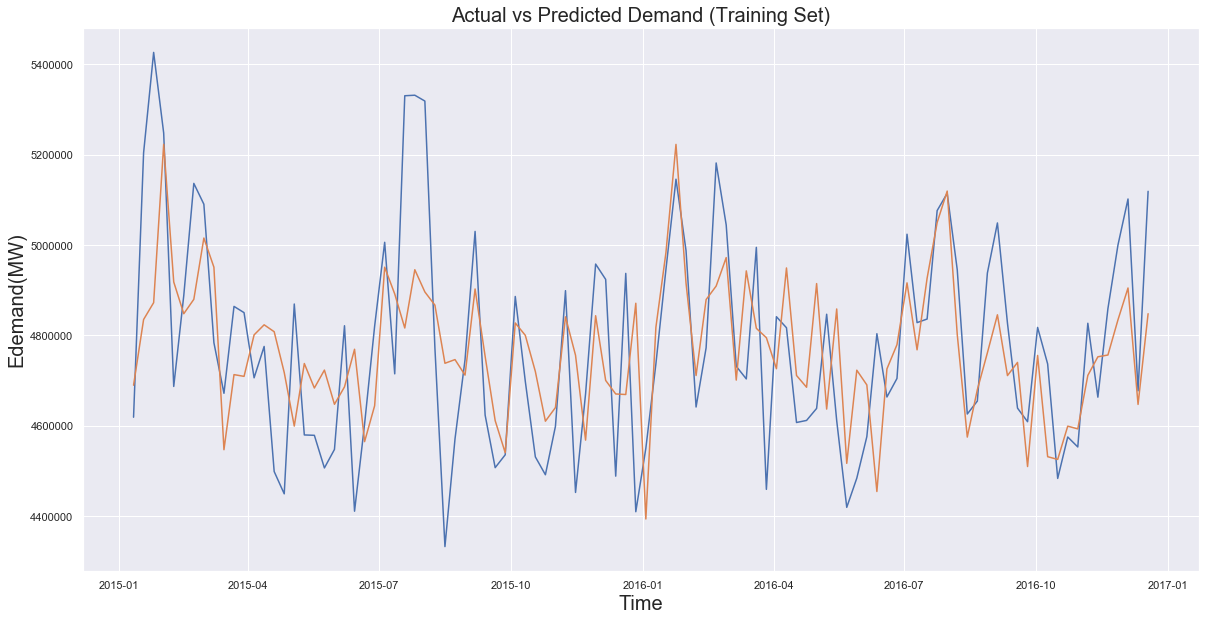

In [495]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])
plt.plot(demand_train[1:-1])
plt.plot(mean_forecast_1)
plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Edemand(MW)", size=20);

In [520]:
#predicting demand on test set
future_1=r1.get_forecast(steps=len(X_test[1:-1]), exog=X_test[1:-1])
mean_future_1=future_1.predicted_mean
f_conf_interval_1=future_1.conf_int()

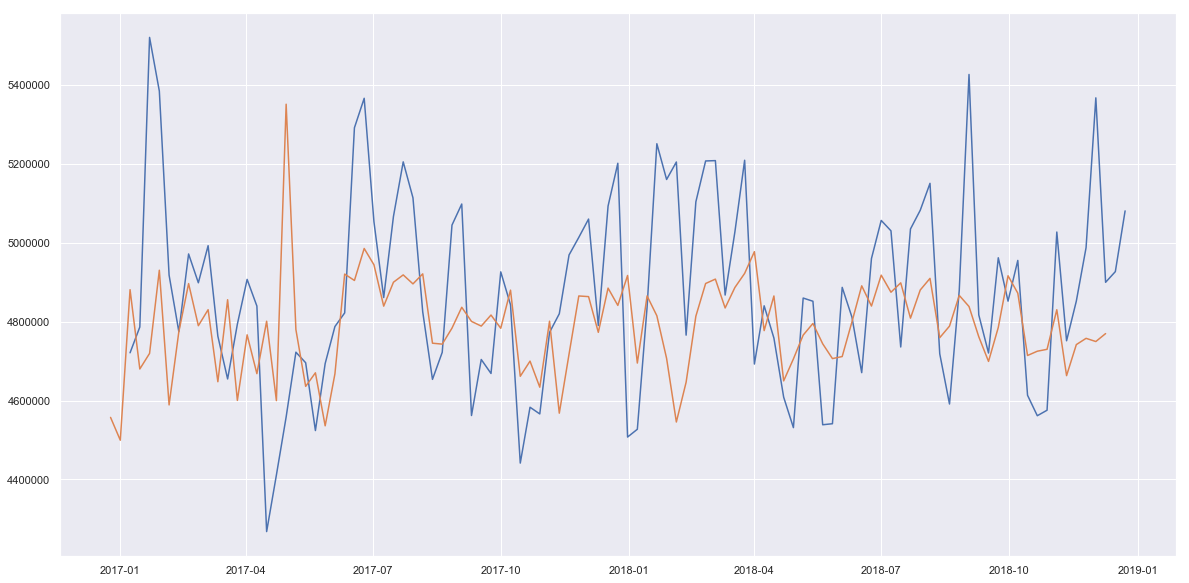

In [521]:
#plotting demand (actual vs predicted) for test set
plt.figure(figsize=[20,10])
plt.plot(demand_test[1:-1])
plt.plot(mean_future_1);

In [522]:
m1_score_test=np.sqrt(mean_squared_error(demand_test[1:-1],mean_future_1))
m1_score_train=np.sqrt(mean_squared_error(demand_train[1:-1],mean_forecast_1))
m1_score_test, m1_score_train

(287478.5227022674, 192286.65643246655)

Let us run the same model while removing features that are not helping the performance.

In [529]:
new_X=pd.DataFrame(data=[x2,x3,x4,x6,x7,x8,x10,x12,x13]).T
new_X_train=new_X.loc[new_X.index.year.isin([2015,2016])].values
new_X_test=new_X.loc[new_X.index.year.isin([2017,2018])].values

In [530]:
#fitting model to low AIC parameters - SARIMA MODEL 2
m2= SARIMAX(demand_train[1:-1], order=(0,0,1), seasonal_order=(1,0,0,52) ,exog=new_X_train[1:-1], trend='c')
r2=m2.fit()

#summary diagnostics
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                  total load actual   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 52)   Log Likelihood               -1385.279
Date:                            Sat, 01 Feb 2020   AIC                           2796.557
Time:                                    17:38:00   BIC                           2830.682
Sample:                                01-11-2015   HQIC                          2810.376
                                     - 12-18-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7203.1216   2.79e+06     -0.003      0.998   -5.48e+06    5.47e+06
x1         -1.177e+04   9518.821     -1.237      0.216   -3.04e+04    6882.391
x2          2.104e+04   1.48e+04      1.426      0.154   -7884.748       5e+04
x3          4644.4171   5222.901      0.889      0.374   -5592.282    1.49e+04
x4          4.337e+04   2.39e+04      1.812      0.070   -3554.034    9.03e+04
x5         -1.778e+06   8.41e+05     -2.114      0.034   -3.43e+06    -1.3e+05
x6          1.792e+06   8.41e+05      2.129      0.033    1.43e+05    3.44e+06
x7          -3.25e+06   8.05e+05     -4.039      0.000   -4.83e+06   -1.67e+06
x8         -1.306e+05   8.83e+04     -1.479      0.139   -3.04e+05    4.25e+04
x9         -1561.3878   3714.565     -0.420      0.674   -8841.801    5719.025
ma.L1          0.2466      0.127      1.946      0.052      -0.002       0.495
ar.S.L52       0.4662      0.141      3.313      0.001       0.190       0.742
sigma2      3.975e+10     43.293   9.18e+08      0.000    3.97e+10    3.97e+10
===================================================================================
Ljung-Box (Q):                       41.18   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.42   Prob(JB):                         0.75
Heteroskedasticity (H):               0.48   Skew:                             0.18
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+26. Standard errors may be unstable.
"""

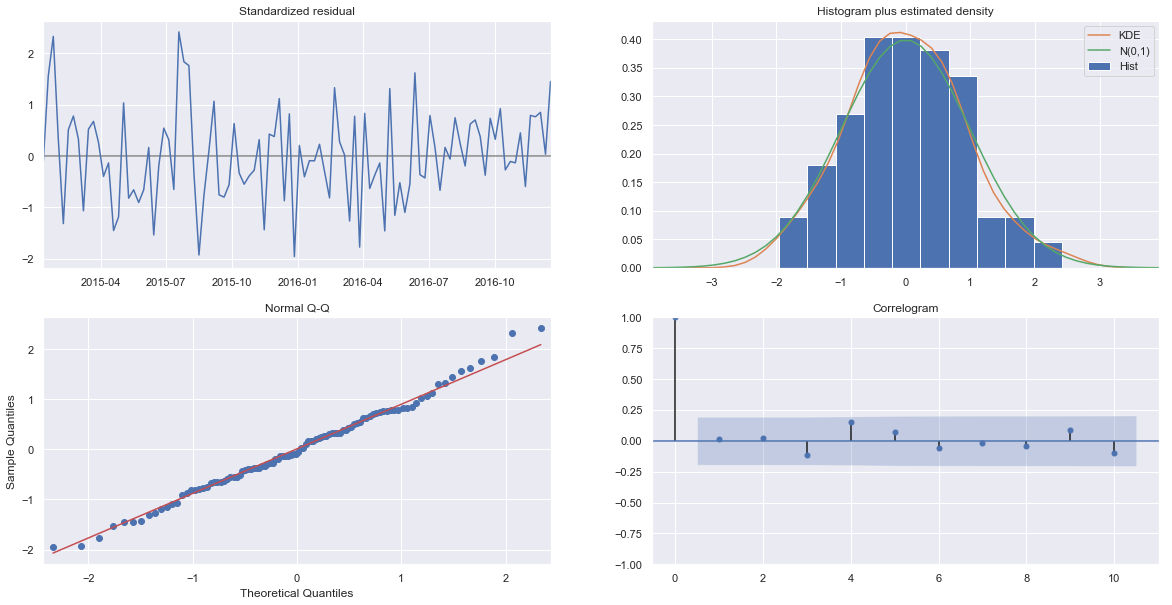

In [531]:
#plotting summary diagnostics
r2.plot_diagnostics(figsize=[20,10]);

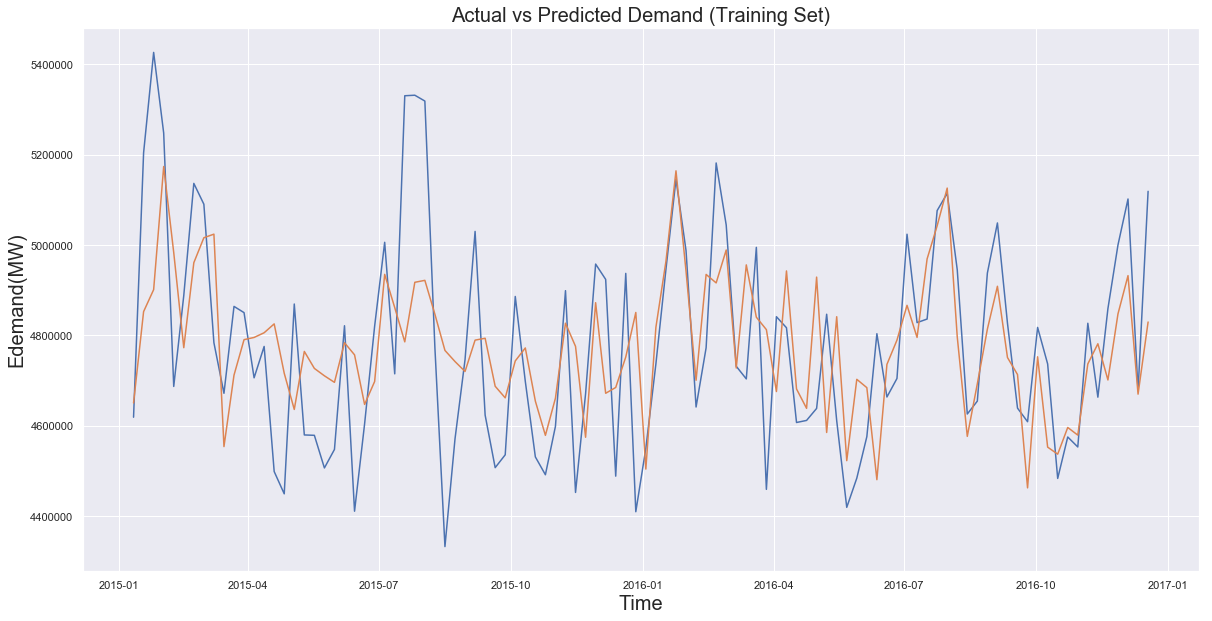

In [534]:
#predicting demand on training set - SARIMA MODEL 2
forecast_2=r2.get_prediction(start=-len(new_X_train[1:-1]), exog=new_X_train[1:-1])
mean_forecast_2=forecast_2.predicted_mean

#plotting demand (actual predicting for test set) - SARIMX model 2
plt.figure(figsize=[20,10])
plt.plot(demand_train[1:-1])
plt.plot(mean_forecast_2)
plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Edemand(MW)", size=20);

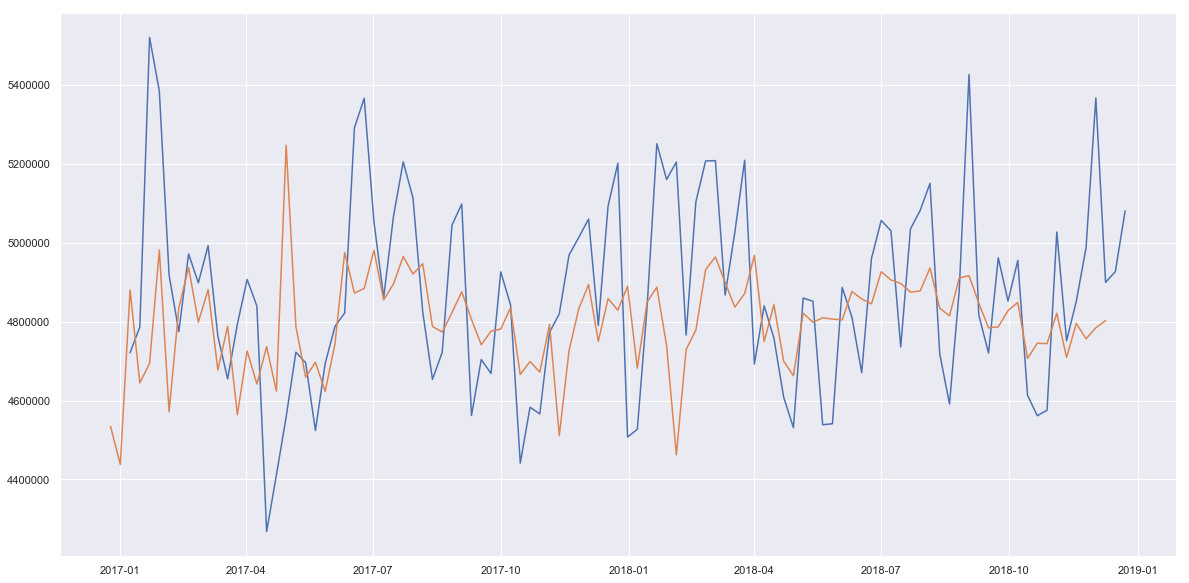

In [540]:
#predicting demand on test set
future_2=r2.get_forecast(steps=len(X_test[1:-1]), exog=new_X_test[1:-1])
mean_future_2=future_2.predicted_mean
f_conf_interval_2=future_2.conf_int()

#plotting demand (actual vs predicted) for test set
plt.figure(figsize=[20,10])
plt.plot(demand_test[1:-1])
plt.plot(mean_future_2);

In [542]:
m2_score_test=np.sqrt(mean_squared_error(demand_test[1:-1],mean_future_2))
m2_score_train=np.sqrt(mean_squared_error(demand_train[1:-1],mean_forecast_2))
m2_score_test, m2_score_train

(277487.7761330794, 192884.38554693636)

# 2. Paramater Estimation - Random Forest and RF with Gradient Boosting 

In [546]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

In [547]:
# Create dict for hyperparameters to find the best
grid = {'n_estimators': [100,150,200,250,300,350,400,500], 'max_depth': [2,3,4,5,6,8,10,13,15], 'max_features': [2,4,5,6,7,8,10,12], 'random_state': [42]}
test_scores = []
rfr=RandomForestRegressor()
# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(X_train[1:-1], demand_train[1:-1])
    test_scores.append(rfr.score(X_test[1:-1], demand_test[1:-1]))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.35444049706422887 {'random_state': 42, 'n_estimators': 150, 'max_features': 12, 'max_depth': 13}


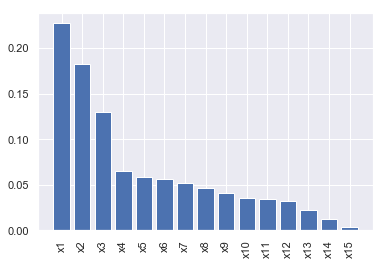

In [550]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15"]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [568]:
from sklearn.ensemble import GradientBoostingRegressor

grid = {'n_estimators': [100,150,200,250,300,350,400,500],
        'max_depth': [2,3,4,5,8,],
        'max_features': [2,4,6,8,10,12], 
        'random_state': [42],
        "subsample":[0.4,0.5,0.7,0.9],
        "learning_rate":[0.001,0.01,0.05,0.1,0.5,0.8,1]}
test_scores = []


# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor()
for g in ParameterGrid(grid):
    gbr.set_params(**g)  # ** is "unpacking" the dictionary
    gbr.fit(X_train[1:-1], demand_train[1:-1])
    test_scores.append(gbr.score(X_test[1:-1], demand_test[1:-1]))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.3963770728542313 {'subsample': 0.9, 'random_state': 42, 'n_estimators': 250, 'max_features': 4, 'max_depth': 2, 'learning_rate': 0.1}


In [569]:
m4= GradientBoostingRegressor(n_estimators=250,max_depth=2,subsample=0.9, learning_rate=0.1, max_features=4)
m4.fit(X_train[1:-1], y=demand_train[1:-1])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [570]:
y_pred=m4.predict(X_test[1:-1])

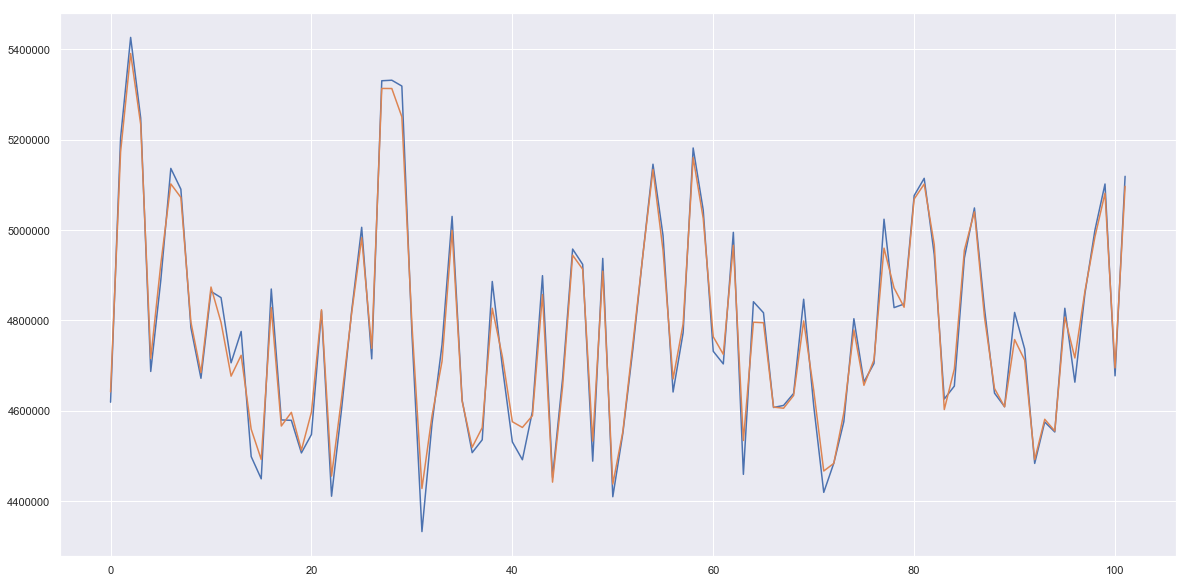

In [571]:
plt.figure(figsize=[20,10])
plt.plot(demand_train[1:-1].values)
plt.plot(m4.predict(X_train[1:-1]));

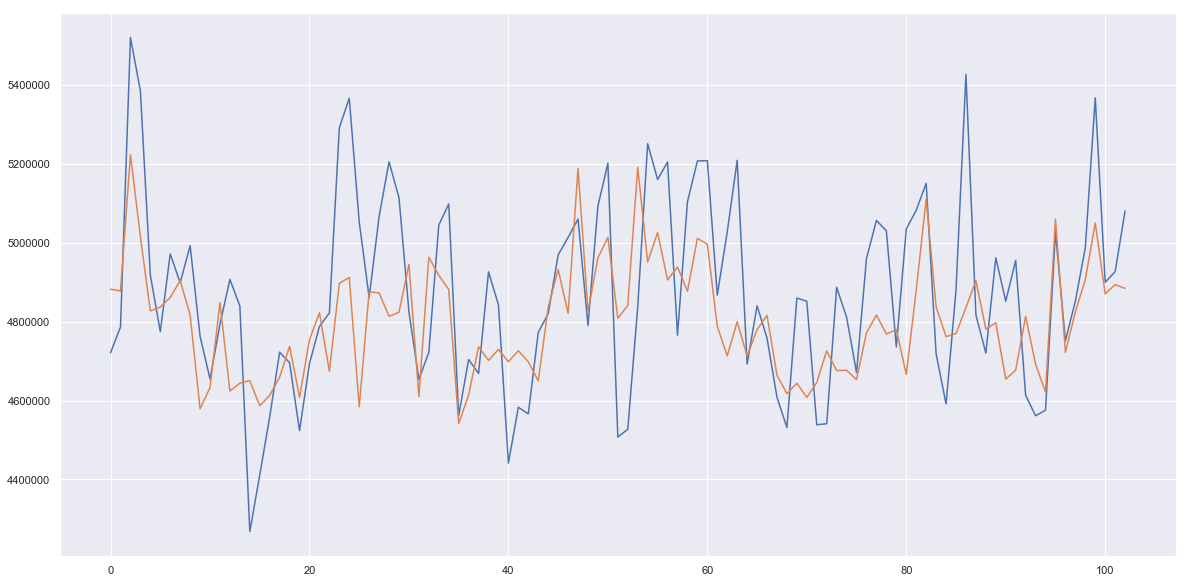

In [572]:
plt.figure(figsize=[20,10])
plt.plot(demand_test[1:-1].values)
plt.plot(y_pred);

In [573]:
m4.score(X_test[1:-1], demand_test[1:-1])

0.29732868536861456

In [574]:
m4.score(X_train[1:-1], demand_train[1:-1])

0.9822436177489412

In [575]:
score_4=mean_squared_error(demand_test[1:-1].values,y_pred)
np.sqrt(score_4)

203857.21893504894

In [ ]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

grid = {'n_estimators': [100,150,200,250,300,350,400,500],
        'max_depth': [2,3,4,5,6,8,10,13,15], 
        'random_state': [42],
        "subsample":[0.4,0.5,0.6,0.7,0.8,0.9],
        "learning_rate":[0.001,0.01,0.05,0.1,0.3,0.5,0.8,1],
         "booster":['gbtree'],
        "objective":['reg:squarederror'],
        "colsample_bynode":[0.5,0.6,0.8,0.9]
       }
test_scores = []


# Create GB model -- hyperparameters have already been searched for you
m_xgb = xgb.XGBRegressor()
for g in ParameterGrid(grid):
    m_xgb.set_params(**g)  # ** is "unpacking" the dictionary
    m_xgb.fit(X_train[1:-1], demand_train[1:-1])
    test_scores.append(m_xgb.score(X_test[1:-1], demand_test[1:-1]))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

In [1146]:
import xgboost as xgb
m3_train_scores=[]
m3_test_scores=[]
ns_3=[]
ds_3=[]
for n in np.linspace(10,1000,50, dtype='int'):
    for d in np.linspace(5,50,30, dtype='int'):
        m3= xgb.XGBRegressor(n_estimators=n, booster='gbtree', subsample=0.8, colsample_bynode=0.8, learning_rate=1, max_depth=d)
        m3.fit(X_train, demand_train)
        m3.fit(X_train, y=demand_train)
        m3_test_scores.append(m3.score(X_test, demand_test))
        m3_train_scores.append(m3.score(X_train, demand_train))
        ns_3.append(n)
        ds_3.append(d)

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be 

[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version




[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:33:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:34:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:34:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:35:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [702]:
m3= xgb.XGBRegressor(n_estimators=1000, booster='gbtree', subsample=0.8, colsample_bynode=0.8, learning_rate=1, max_depth=5)
reg.fit(X_train, demand_train)

[00:13:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\yfawz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.8, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
plt.figure(figsize=[20,10])
plt.plot(demand_test.values)
plt.plot(m3.predict(X_test));

In [ ]:
m3.score(X_test, demand_test)

In [ ]:
m3.score(X_train, demand_train)

In [1327]:
demand_train1=demand_actual[demand_actual.index.year.isin([2015,2016])].resample("W").sum()[1:-1]
demand_test1=demand_actual[demand_actual.index.year.isin([2017,2018])].resample("W").sum()[1:-1]
X1=pd.DataFrame(data=[x1,x2,x3,x4,x5,x6,x7,x8]).T
X_train1=X.loc[X.index.year.isin([2015,2016])].values
X_test1=X.loc[X.index.year.isin([2017,2018])].values
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=3,
                                learning_rate=0.03,
                                n_estimators=200,
                                subsample=0.7,
                                random_state=42)
gbr.fit(X_train1, demand_train1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=3,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1328]:
print(gbr.score(X_train1, demand_train1))
print(gbr.score(X_test1, demand_test1))

0.8852655375083192
0.1461009860057626
